In [21]:
using LinearAlgebra
using StaticArrays
using StaticArrays, ArraysOfArrays, StructArrays
using DataStructures
using Distributions
using StatsBase
using CairoMakie

In [1]:
using Newtrinos

[ Info: Precompiling Newtrinos [5b289081-bab5-45e8-97fc-86872f1653a0] (cache misses: include_dependency fsize change (4), incompatible header (6), dep uuid changed (2))
[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xd22849a0fa6a9874, 0x25ca03052ce426c4, 0x3c7b97ece45ec53a, 0x78b524ea01e1a004, 0xe66fd250f664acd5, 0xd166ef774371b03e, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())


In [252]:
include("eigen_hermitian_3x3.jl")

_sorted_eigen (generic function with 3 methods)

In [2]:
cz_bins = LinRange(-1,1,201);
e_bins = 10. .^ LinRange(0,3,201);

In [17]:
layers = Newtrinos.earth_layers.compute_layers();

In [19]:
layers.radius

5-element Vector{Any}:
 6391.0
 6371.0
 5701.0
 3480.0
 1221.5

In [210]:
paths = Newtrinos.earth_layers.compute_paths(midpoints(cz_bins), layers);

In [36]:
const N_A = 6.022e23 #[mol^-1]
const G_F = 8.961877245622253e-38 #[eV*cm^3]
const A = sqrt(2) * G_F * N_A

7.632287825408278e-14

In [390]:
# Oscillation Kernel Simple
function osc_kernel(U::AbstractMatrix{<:Number}, H::AbstractVector, e::Real, l::Real)
    phase_factors = exp.(2.5338653580781976 * 1im * (l / e) .* H)
    U * Diagonal(phase_factors) * U'
end

osc_kernel (generic function with 1 method)

In [39]:
function get_PMNS(params)
    T = typeof(params.θ₂₃)
    #T = ftype

    U1 = SMatrix{3,3}(one(T), zero(T), zero(T), zero(T), cos(params.θ₂₃), -sin(params.θ₂₃), zero(T), sin(params.θ₂₃), cos(params.θ₂₃))
    U2 = SMatrix{3,3}(cos(params.θ₁₃), zero(T), -sin(params.θ₁₃)*exp(1im*params.δCP), zero(T), one(T), zero(T), sin(params.θ₁₃)*exp(-1im*params.δCP), zero(T), cos(params.θ₁₃))
    U3 = SMatrix{3,3}(cos(params.θ₁₂), -sin(params.θ₁₂), zero(T), sin(params.θ₁₂), cos(params.θ₁₂), zero(T), zero(T), zero(T), one(T))
    U = U1 * U2 * U3
end

get_PMNS (generic function with 1 method)

In [40]:
function get_matrices(params)
    U = get_PMNS(params)
    H = Diagonal(SVector(zero(typeof(params.θ₂₃)),params.Δm²₂₁,params.Δm²₃₁));
    return U, H
end

get_matrices (generic function with 1 method)

In [257]:
fast_eigen(Hermitian(H_eff))

Eigen{ComplexF64, Float64, SMatrix{3, 3, ComplexF64, 9}, SVector{3, Float64}}
values:
3-element SVector{3, Float64} with indices SOneTo(3):
 -1.951563910473908e-18
  7.530000000000221e-5
  0.0024752999999999997
vectors:
3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 -0.373264-0.734249im   0.248438+0.488704im  -0.0656701-0.12918im
  0.118632+0.402481im   0.278006+0.434303im    0.377438-0.644648im
 -0.229537-0.304634im  -0.258211-0.605696im    0.327825-0.559911im

In [425]:
function compute_matter_matrices(H_eff, e, layer, anti)
    H = MMatrix{3, 3}(H_eff)
    if anti
        H[1,1] -= A * layer.p_density * 2 * e * 1e9
        for i in 1:3
            H[i,i] += A * layer.n_density * e * 1e9
        end
    else
        H[1,1] += A * layer.p_density * 2 * e * 1e9
        for i in 1:3
            H[i,i] -= A * layer.n_density * e * 1e9
        end
    end
    H = Hermitian(SMatrix(H))
    #H
    #tmp = eigen(H)
    tmp = fast_eigen(H)
    tmp.vectors, tmp.values
end    

compute_matter_matrices (generic function with 2 methods)

In [405]:
@time um, hm = compute_matter_matrices.(Ref(H_eff), 1., layers, false)

  0.000069 seconds (27 allocations: 2.312 KiB)


5-element StructArray(::Vector{SMatrix{3, 3, ComplexF64, 9}}, ::Vector{SVector{3, Float64}}) with eltype Tuple{SMatrix{3, 3, ComplexF64, 9}, SVector{3, Float64}}:
 ([-0.37326379676412813 - 0.7342486894950802im 0.24843823760091868 + 0.48870383884085533im -0.06567008122693825 - 0.12917987626425198im; 0.11863156798452598 + 0.40248061129095525im 0.2780056832686773 + 0.43430260036371265im 0.3774378232709056 - 0.6446477251681886im; -0.2295371337039938 - 0.3046335714646886im -0.2582114608454883 - 0.6056962381224048im 0.32782511246639917 - 0.5599113283694059im], [-1.951563910473908e-18, 7.530000000000221e-5, 0.0024752999999999997])
 ([-0.06886595066345971 - 0.13546648366069367im 0.4419140558265493 + 0.8692908853551125im -0.07300292834888185 - 0.14360434881216738im; 0.28424633380968395 + 0.5935877102388565im 0.10647796659555023 - 0.01374478626606708im 0.37641251790165736 - 0.6431522306703573im; -0.34619593475079036 - 0.651085508497153im 8.220727712133072e-5 - 0.19369780748267315im 0.32707510854

In [402]:
hm

3-element SVector{3, Float64} with indices SOneTo(3):
 -1.951563910473908e-18
  7.530000000000221e-5
  0.0024752999999999997

In [ ]:
mapreduce(

In [338]:
zeros(eltype(um), (2,2))

2×2 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im

In [411]:
function osc_reduce(matter_matrices, path, e, anti::Bool)
    mapreduce(section -> osc_kernel(matter_matrices[section.layer_idx]..., e, section.length), *, path)
end

osc_reduce (generic function with 2 methods)

In [412]:
function matter_osc_per_e(H_eff, e, layers, paths, anti)
    matter_matrices = compute_matter_matrices.(Ref(H_eff), e, layers, anti)
    stack([(osc_reduce(matter_matrices, path, e, anti)) for path in paths])
end

matter_osc_per_e (generic function with 1 method)

In [413]:
function osc_prob(E::AbstractVector{<:Real}, paths::VectorOfVectors{Newtrinos.osc.Path}, layers::StructVector{Newtrinos.osc.Layer}, params::NamedTuple; anti=false)
    U, H = get_matrices(params);
    Uc = anti ? conj.(U) : U
    H_eff = Uc * Diagonal{Complex{eltype(H)}}(H) * adjoint(Uc)

    p = abs2.(stack([matter_osc_per_e(H_eff, e, layers, paths, anti) for e in E]) )
    permutedims(p, (4, 3, 1, 2))
end

osc_prob (generic function with 1 method)

In [438]:
@benchmark p_earth = osc_prob($midpoints(e_bins), $paths, $layers, $NamedTuple(Newtrinos.osc.standard.params), anti=false)

BenchmarkTools.Trial: 192 samples with 1 evaluation per sample.
 Range (min … max):  14.439 ms … 99.964 ms  ┊ GC (min … max):  0.00% … 78.56%
 Time  (median):     26.421 ms              ┊ GC (median):    30.12%
 Time  (mean ± σ):   26.005 ms ±  9.775 ms  ┊ GC (mean ± σ):  23.89% ± 17.63%

   ▆█ ▄         ▁ ▂ █▄▂  ▁ ▁                                   
  ▅██▅█▃▅▄▄▄▇▆▆▆█▆██████▆█▆█▆▅▄▁▃▁▁▅▁▁▃▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃ ▃
  14.4 ms         Histogram: frequency by time        56.5 ms <

 Memory estimate: 52.84 MiB, allocs estimate: 293261.

In [437]:
@time p_earth = osc_prob(midpoints(e_bins), paths, layers, NamedTuple(Newtrinos.osc.standard.params), anti=false);

  0.027986 seconds (293.26 k allocations: 52.837 MiB, 28.00% gc time)


In [90]:
using BenchmarkTools

In [369]:
@btime p_earth = Newtrinos.osc.standard.osc_prob(midpoints(e_bins), paths, layers, NamedTuple(Newtrinos.osc.standard.params), anti=false);

  41.820 ms (841263 allocations: 76.40 MiB)


In [69]:
using ForwardDiff

In [416]:
test(p) = sum(osc_prob(midpoints(e_bins), paths, layers, p, anti=false);)

test (generic function with 1 method)

In [417]:
@time test(NamedTuple(Newtrinos.osc.standard.params))

  0.065988 seconds (385.10 k allocations: 57.305 MiB, 21.77% gc time, 43.09% compilation time)


120000.0

In [421]:
@time ForwardDiff.gradient(test, NamedTuple(Newtrinos.osc.standard.params))

  0.321825 seconds (293.50 k allocations: 343.522 MiB, 11.66% gc time)


(θ₁₂ = -6.905054306116654e-11, θ₁₃ = -1.3869794202037156e-10, θ₂₃ = -6.866684998385608e-11, δCP = 2.9913849175500218e-12, Δm²₂₁ = 3.059394657611847e-7, Δm²₃₁ = 5.145557224750519e-8)

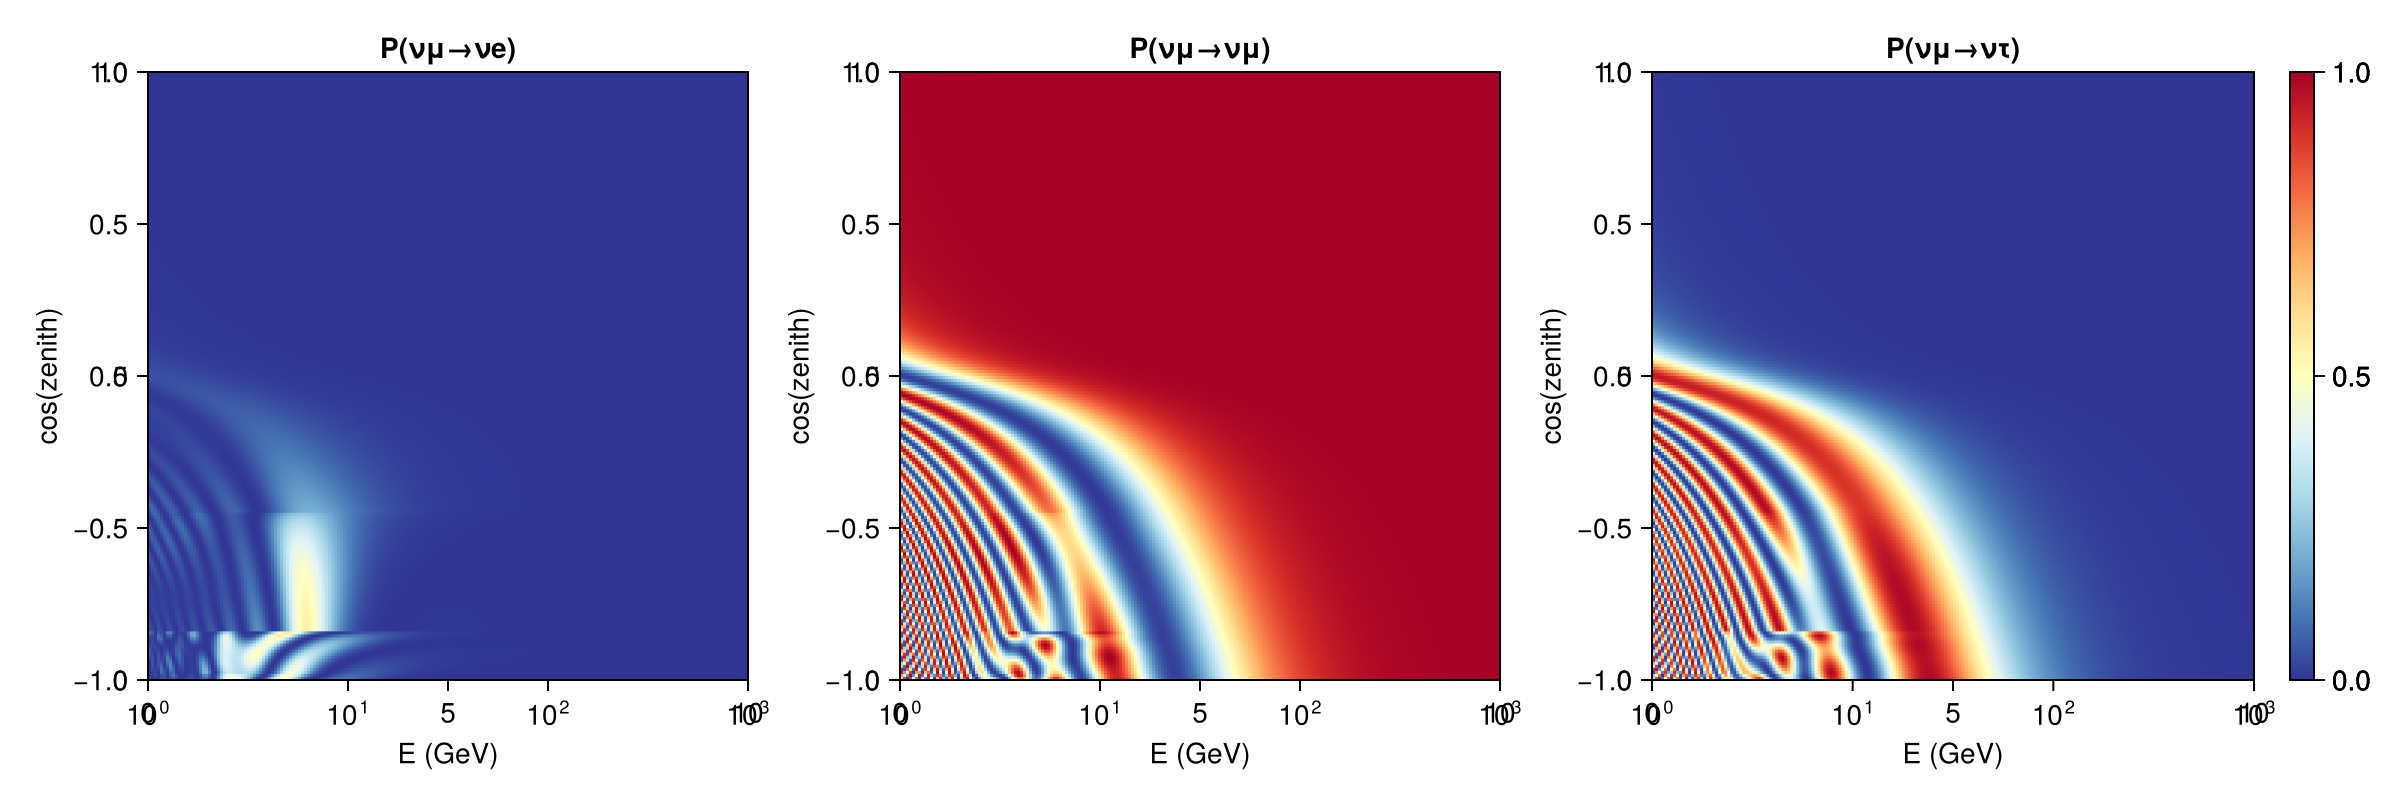

In [410]:
fig = Figure(size=(1200,400))
for i in 1:3
    ax = Axis(fig[1,i], xscale=log10, xlabel="E (GeV)", ylabel=("cos(zenith)"))
    hm = heatmap!(ax, e_bins, cz_bins, p_earth[:, :, 2,i], colormap=Reverse(:RdYlBu), colorrange=(0,1))
    Colorbar(fig[1,4], hm)
end

Axis(fig[1,1]).title = "P(νμ→νe)"
Axis(fig[1,2]).title = "P(νμ→νμ)"
Axis(fig[1,3]).title = "P(νμ→ντ)"
save("MSW.png",fig)
fig

In [166]:
using Neurthino

[ Info: Precompiling Neurthino [ea3506b1-7c4e-45d8-9afb-6e8d18a7dde4] (cache misses: wrong dep version loaded (2), incompatible header (4))


In [168]:
zenith = acos.(midpoints(cz_bins));

In [478]:
prempaths = Neurthino.prempath(zenith, 22.5, samples=100, discrete_densities=0:0.1:14);

In [195]:
U, H = get_matrices( NamedTuple(Newtrinos.osc.standard.params))

(ComplexF64[0.8236789423070132 + 0.0im 0.5482271427063785 + 0.0im 0.07829724271170094 - 0.12194073061838277im; -0.4125414811720368 - 0.07663953092234524im 0.5131314524521445 - 0.051010009966059956im 0.7470140560926547 + 0.0im; 0.37557680154163764 - 0.06656556734632532im -0.6569460884857622 - 0.044304945670570195im 0.6488220094910468 + 0.0im], [0.0 0.0 0.0; 0.0 7.53e-5 0.0; 0.0 0.0 0.0024752999999999997])

In [442]:
@time p_earth = osc_prob(midpoints(e_bins), paths, layers, NamedTuple(Newtrinos.osc.standard.params), anti=false);

  0.031239 seconds (293.26 k allocations: 52.837 MiB, 26.90% gc time)


In [479]:
@time prob = Pνν(Matrix(U), H, midpoints(e_bins), prempaths);

  3.014818 seconds (79.72 M allocations: 4.990 GiB, 30.95% gc time)


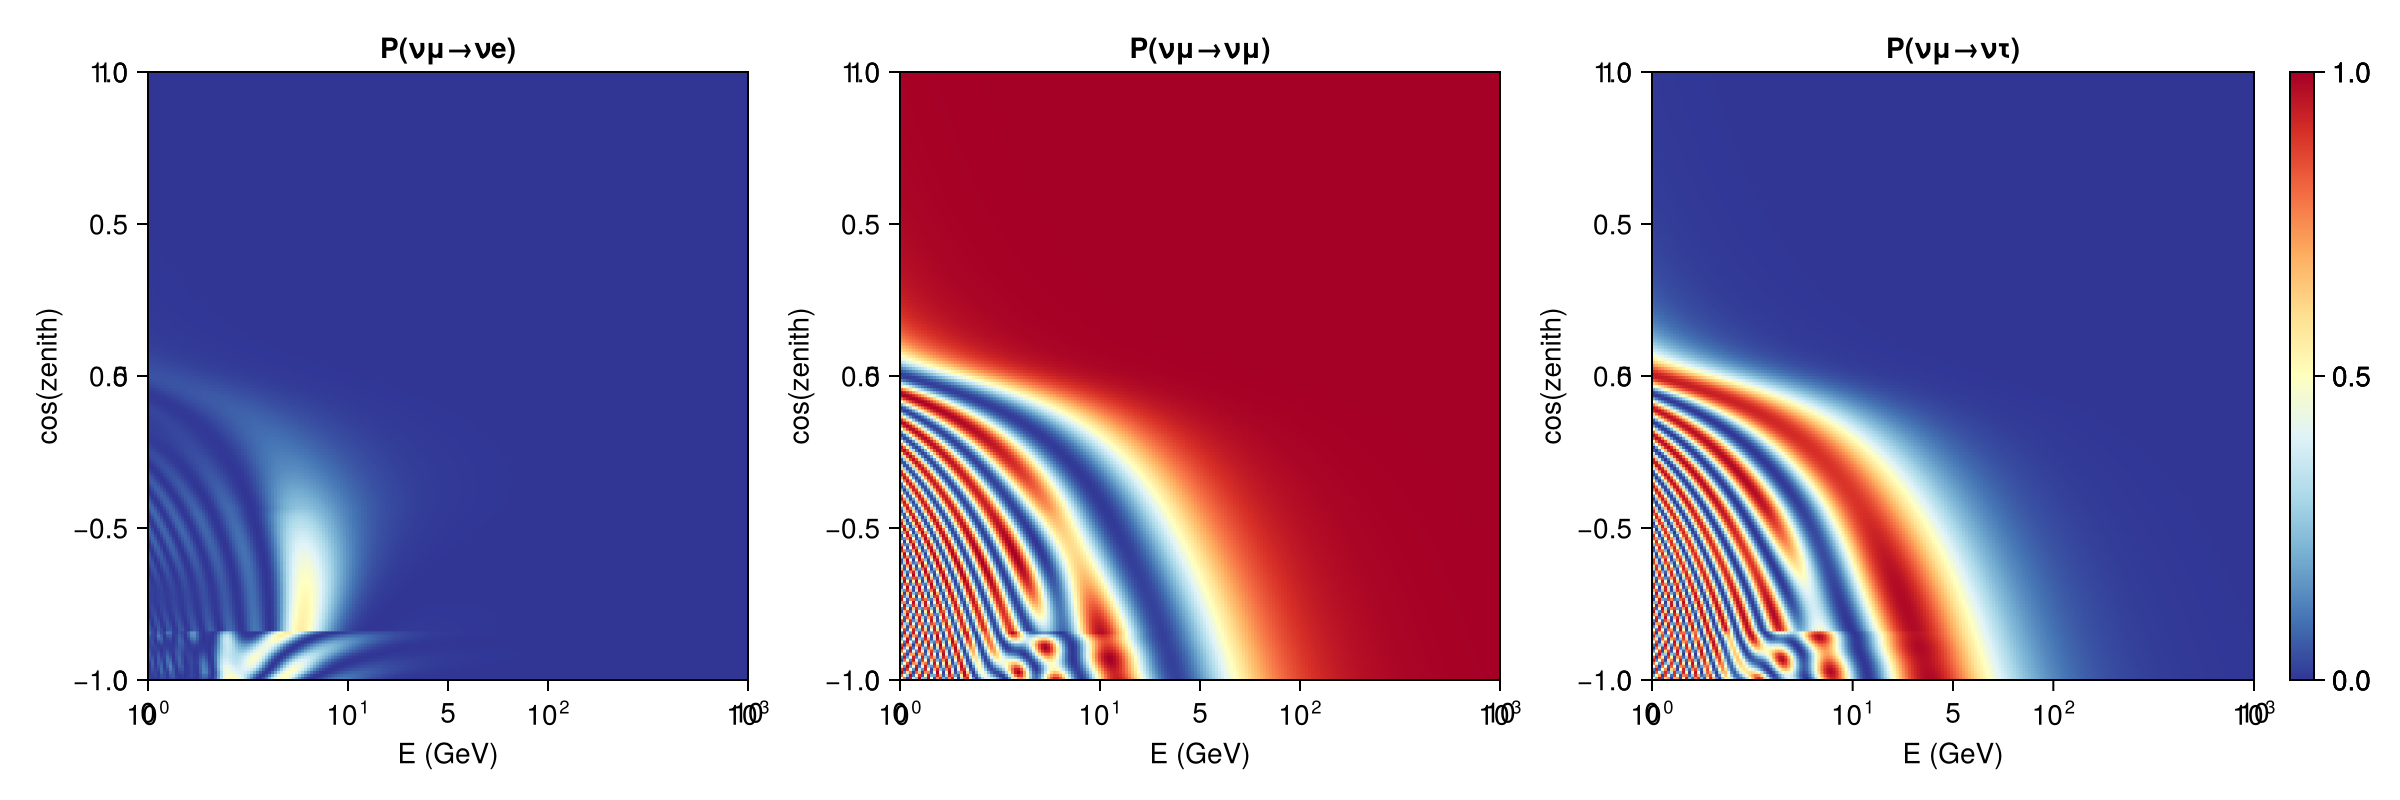

In [480]:
fig = Figure(size=(1200,400))
for i in 1:3
    ax = Axis(fig[1,i], xscale=log10, xlabel="E (GeV)", ylabel=("cos(zenith)"))
    hm = heatmap!(ax, e_bins, cz_bins, prob.data[:, :, 2,i], colormap=Reverse(:RdYlBu), colorrange=(0,1))
    Colorbar(fig[1,4], hm)
end

Axis(fig[1,1]).title = "P(νμ→νe)"
Axis(fig[1,2]).title = "P(νμ→νμ)"
Axis(fig[1,3]).title = "P(νμ→ντ)"
fig

In [481]:
reldiff = abs.((prob.data .- p_earth));

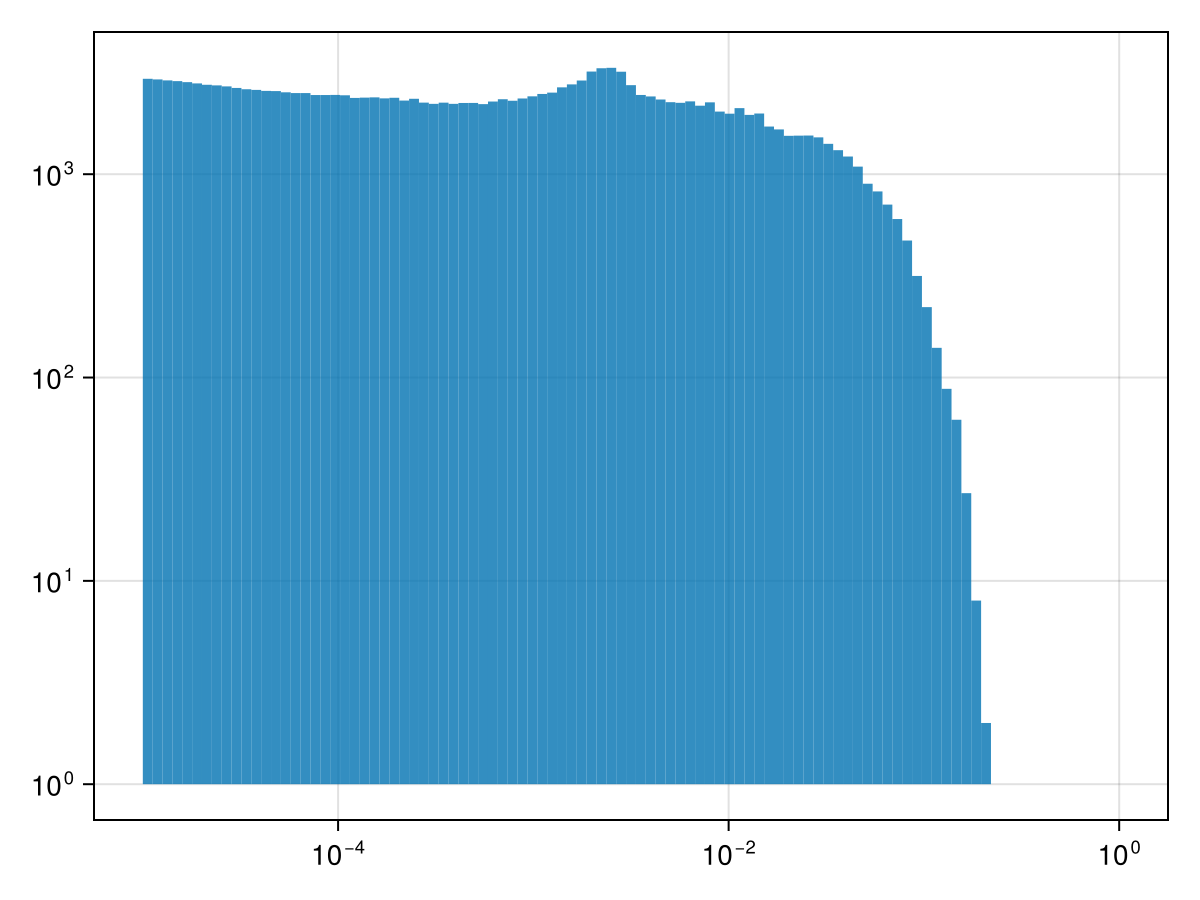

In [482]:
fig = Figure()
ax = Axis(fig[1,1], yscale=log10, xscale=log10)
hist!(ax, reldiff[:], bins = 10. .^LinRange(-5,0,100))
fig